# Fleet optimization

This notebook shows how to implement a basic feeder concept for one cutter suction dredger working with multiple barges. We run a large number of possible barge configurations and rank the fleets considering three types of KPIs: the shortest, cheapest and most energy efficient scenario. The best simulation is explored, and exported for further analysis with BI tools. This notebook is the use case in the paper: de Boer et al,. (2023). "Simulating for sustainability: alternative operating strategies for energy efficiency." Terra et Aqua (170). url: https://www.iadc-dredging.com/wp-content/uploads/2023/06/Terra-et-Aqua_170-Summer-2023-TECHNICAL-double-pages.pdf

In [1]:
import time
import simpy
import shapely.geometry
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline

import openclsim.core as core
import openclsim.model as model
from openclsim.plot import get_step_chart, get_gantt_chart

from openclsim.io import get_activity_resources, get_activity_log, get_activities, get_concepts
from openclsim.io import get_tree_as_list, get_ranges_dataframe

In [2]:
cutter_name = 'Cutter T'

# Define or import a vessel database

In [3]:
barge_empty = 1000 # kW
barge_full = 2500 # kW
barge_loading = 1000 # kW
barge_unloading = 2500 # kW
barge_WAIT = 20 # kW

# does not specify enery use or rates per operating mode: mover, processor, origin of destination: one overall value
# proper databases should have a uiuid as key, and not the vessel_name
vessel_specs = pd.DataFrame.from_dict(
       {'rates [€/day]':{'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                         'Barge I':5000,'Barge II':5000,'Barge III':5000,
                         'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                         cutter_name:25000}, # EUR/day
   'sailing empty [kW]':{'Carrier A':barge_empty,'Carrier B':barge_empty,'Carrier C':barge_empty,
                         'Barge I':barge_empty,'Barge II':barge_empty,'Barge III':barge_empty,
                         'Extra 1':barge_empty, 'Extra 2':barge_empty, 'Extra 3':barge_empty,
                         cutter_name:1000},
         'loading [kW]':{'Carrier A':barge_loading,'Carrier B':barge_loading,'Carrier C':barge_loading,
                         'Barge I':barge_loading,'Barge II':barge_loading,'Barge III':barge_loading,
                         'Extra 1':barge_loading, 'Extra 2':barge_loading, 'Extra 3':barge_loading,
                         cutter_name:15000},
    'sailing full [kW]':{'Carrier A':barge_full,'Carrier B':barge_full,'Carrier C':barge_full,
                         'Barge I':barge_full,'Barge II':barge_full,'Barge III':barge_full,
                         'Extra 1':barge_full, 'Extra 2':barge_full, 'Extra 3':barge_full,
                         cutter_name:1000},
       'unloading [kW]':{'Carrier A':barge_unloading,'Carrier B':barge_unloading,'Carrier C':barge_unloading,
                         'Barge I':barge_unloading,'Barge II':barge_unloading,'Barge III':barge_unloading,
                         'Extra 1':barge_unloading, 'Extra 2':barge_unloading, 'Extra 3':barge_unloading,
                         cutter_name:1000}, # standby power
            'WAIT [kW]':{'Carrier A':barge_WAIT,'Carrier B':barge_WAIT,'Carrier C':barge_WAIT,
                         'Barge I':barge_WAIT,'Barge II':barge_WAIT,'Barge III':barge_WAIT,
                         'Extra 1':barge_WAIT, 'Extra 2':barge_WAIT, 'Extra 3':barge_WAIT,
                         cutter_name:500}, # hotel power
          'vessel_type':{'Carrier A':'barge','Carrier B':'barge','Carrier C':'barge',
                         'Barge I':'barge','Barge II':'barge','Barge III':'barge',
                         'Extra 1':'barge', 'Extra 2':'barge', 'Extra 3':'barge',
                         cutter_name:'CSD'},
        'capacity [M3]':{'Carrier A':2500,'Carrier B':2500,'Carrier C':2500,
                         'Barge I':3000,'Barge II':3000,'Barge III':3000,
                         'Extra 1':2000, 'Extra 2':2000, 'Extra 3':2000,
                         cutter_name:0},
    'production [M3/s]':{'Carrier A':0,'Carrier B':0,'Carrier C':0,
                         'Barge I':0,'Barge II':0,'Barge III':0,
                         'Extra 1':0, 'Extra 2':0, 'Extra 3':0,
                         cutter_name:0.6},
    'speed [m/s]':     {'Carrier A':10,'Carrier B':10,'Carrier C':10,
                         'Barge I':12.5,'Barge II':12.5,'Barge III':12.5,
                         'Extra 1':15, 'Extra 2':15, 'Extra 3':15,
                         cutter_name:0},
})

vessel_specs.index.name = 'vessel_name'
# For large vessel databases, one would import an external source.
# Here we save to csv and read it again as example. 
vessel_specs.to_csv('vessel_specs.csv', index=True)
vessel_specs = pd.read_csv('vessel_specs.csv', index_col='vessel_name')
vessel_specs # us: vessel_specs.loc[cutter_name][property]

rates [€/day]  sailing empty [kW]  loading [kW]  \
vessel_name                                                    
Carrier A             6000                1000          1000   
Carrier B             6000                1000          1000   
Carrier C             6000                1000          1000   
Barge I               5000                1000          1000   
Barge II              5000                1000          1000   
Barge III             5000                1000          1000   
Extra 1               4000                1000          1000   
Extra 2               4000                1000          1000   
Extra 3               4000                1000          1000   
Cutter T             25000                1000         15000   

             sailing full [kW]  unloading [kW]  WAIT [kW] vessel_type  \
vessel_name                                                             
Carrier A                 2500            2500         20       barge   
Carrier B                 2500            2500         20       barge   
Carrier C                 2500            2500         20       barge   
Barge I                   2500            2500         20       barge   
Barge II                  2500            2500         20       barge   
Barge III                 2500            2500         20       barge   
Extra 1                   2500            2500         20       barge   
Extra 2                   2500            2500         20       barge   
Extra 3                   2500            2500         20       barge   
Cutter T                  1000            1000        500         CSD   

             capacity [M3]  production [M3/s]  speed [m/s]  
vessel_name                                                 
Carrier A             2500                0.0         10.0  
Carrier B             2500                0.0         10.0  
Carrier C             2500                0.0         10.0  
Barge I               3000                0.0         12.5  
Barge II              3000                0.0         12.5  
Barge III             3000                0.0         12.5  
Extra 1               2000                0.0         15.0  
Extra 2               2000                0.0         15.0  
Extra 3               2000                0.0         15.0  
Cutter T                 0                0.6          0.0

## Define the project, incl. a range of barge scenarios

sailing_distance: 30000 [m]


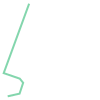

In [4]:
sailing_route = shapely.geometry.LineString(
       [[4.04839542610522, 51.93448660268876],
        [4.07861747008570, 51.94120388210722],
        [4.08771447427120, 51.96880414399069],
        [4.07914412011011, 51.97935797279904],
        [4.03829179430913, 51.99335914771166],
        [4.10293260415299, 52.16986439264421]]) # 30 km

from_site_name, from_site_location = "Trench", shapely.geometry.Point(sailing_route.coords[0])
to_site_name, to_site_location = "Reclamation", shapely.geometry.Point(sailing_route.coords[-1])
from pyproj import Geod
geod = Geod(ellps="WGS84")
sailing_distance = geod.geometry_length(sailing_route) # [m]
print(f"sailing_distance: {sailing_distance:.0f} [m]")
sailing_route

In [5]:
import folium
m = folium.Map((52.05,4.05), zoom_start=11)
folium.Marker(from_site_location.coords[0][::-1], popup="<b>Port</b>", tooltip="Port").add_to(m)
folium.Marker(to_site_location.coords[0][::-1], popup="<b>Dump</b>", tooltip="Dump").add_to(m)
folium.PolyLine([x[::-1] for x in sailing_route.coords[:]], color="red", weight=2.5).add_to(m)
m

In [6]:
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
# verify that our fleet selection exists in the vessel database 
assert all([x in vessel_specs.index for x in barge_names])
assert cutter_name in vessel_specs.index

# In this example the model Activity.name will be predefined structure
# to enable post-processing in BI: <activity_type>:<activity_label> 
# where activity_type consitutes a governed list that can be used for
# example to assign energy consumption. Here is ABS=ActivtryBreakdopwnStructure

ABS = { 'SE':'sailing empty',
        'LO':'loading',
        'SF':'sailing full',
        'UL':'unloading',
        'WA':'while_sequential_activity_subcycle',
        'SA':'sequential_activity_subcycle'}

# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

load_factor_perc_range = [40,60] # [%] percentage of capacity that is actually loaded due to navigable depth etc
unload_duration_range = [2000,3000] # time needed barge unloading in Dump area

from_site_name, from_site_location = 'Trench', shapely.geometry.Point(sailing_route.coords[0]) #shapely.geometry.Point(4.18055556, 52.18664444)
to_site_name, to_site_location   = 'Reclamation', shapely.geometry.Point(sailing_route.coords[-1]) #shapely.geometry.Point(4.25222222, 52.11428333)
total_amount = 30000 # [M3]

nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
simulation_start = 0

In [7]:
Site = type(
    "Site",
    ( # the order may matter: if you get a MRO error: add the specific first, and the generic (core.Log) last
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    ( # the order may matter: if you get a MRO error: add the specific first, and the generic (core.Log) last
        core.Identifiable,
        core.ContainerDependentMovable,
        core.movable.Routable, # allow for sailing_route
        core.Processor,
        core.HasResource,
        core.Log,
    ),
    {},
)

In [8]:
def run(barge_list, total_amount, vessel_specs, simulation_start=0):
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": from_site_location,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": to_site_location,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(len(barge_list)):
        vessel_name = barge_list[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=from_site_location, 
            capacity=vessel_specs.loc[vessel_name]['capacity [M3]'],
            compute_v=lambda x: vessel_specs.loc[vessel_name]['speed [m/s]'],
            path=sailing_route,
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=from_site_location, 
        capacity=0,
        compute_v=0
    )
    vessels[cutter_name] = cutter
    
    activities = {}
    for i in range(len(barge_list)):
        vessel_name = barge_list[i]
        load_factor = random.randint(load_factor_perc_range[0], load_factor_perc_range[1])/100. # [0..1]
        unload_duration=random.randint(unload_duration_range[0], unload_duration_range[1]) # sailing and unloading
        sailing_duration = sailing_distance/vessel_specs.loc[vessel_name]['speed [m/s]']

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=ABS['WA']+':'+f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=ABS['SA']+':'+f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
                    model.MoveActivity(
                        env=my_env,
                        name=ABS['SE']+': sailing empty '+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=sailing_duration, # will not be used if path is supplied
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=ABS['LO']+': loading '+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=load_factor*vessel_specs.loc[vessel_name]['capacity [M3]'],
                        duration=load_factor*vessel_specs.loc[vessel_name]['capacity [M3]']/vessel_specs.loc[cutter_name]['production [M3/s]'],
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=ABS['SF']+': sailing full '+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=sailing_duration, # will not be used if path is supplied
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=ABS['UL']+': unloading '+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=load_factor*vessel_specs.loc[vessel_name]['capacity [M3]'],
                        duration=unload_duration, # [s] dumping while sailing slowly over dumping ground
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


## Define a project specific extractor to get KPIs from simulation results

In [9]:
def simulation_analysis(results, vessel_specs, cutter_name, total_amount):
    """Extract specific information from simulation results.
    
    Parameters
    ----------
    results
        dataframes with OpenCLSim vessel, activities log 
    vessel_specs
        dataframe with vessel properties (rates, energy use)
        each row is a vessel (index), each column is a property
    cutter_name
        name of the one cutter_vessel among the vessels. simulation_analysis asumes that 
        1 cutter services many barges, 1 at a time. The cutter processes the same amlunt as the sum of all barges:
    total_amount
        amount processed by cutter, and by the fleet of barges
    
    Results
    ----------
    df
        Dataframe of integrated vessels kpis for scenario: e.g. fuel, occupancy, cost
    kpi
        Dataframe with a row of overall simulation kpis
    
    Assumes
    * all vessels arrive JIT when they need to start
    * al vessels leave immediately when they are done (so different demob times)
    This is an overestimation of actual occupancy, a mob/demob, initial waiting, 
    and final waiting are considered gratis.
    
    """
    
    vessels = results['vessels']
    activities = results['activities']
    sites = results['sites']
    
# for each fleet member    
    
    data = []
    
    activity_resources =  get_activity_resources(activities, 'resources.csv')
    activity_resources['ActivityType'] = [x['ActivityName'].split(':')[0] for _,x in activity_resources.iterrows()]    
    
    for i, vessel_name in enumerate(vessels):
        vessel = vessels[vessel_name]

        log = get_ranges_dataframe(vessel)
        
        duration_theory = log.TimestampDt.sum()
        duration_actual = (log.TimestampStop.max() - log.TimestampStart.min()).total_seconds()
        nr_trips = len(log.groupby('trip'))

        mask = activity_resources['ConceptName']==vessel.name
        # ConceptMode is not dependent on mover or processor (not origin): vessel_specs is combined mode
        log2 = log.merge(activity_resources[mask].groupby('ConceptMode').max(), left_on='Activity', right_on='ActivityID', how='left')
        log2 = log2[['TimestampDt','ActivityType']]
        log3 = log2.groupby('ActivityType').sum()
        MWha = [vessel_specs.loc[vessel.name][ActivityType + ' [kW]']*x['TimestampDt']/3600/1e3 for ActivityType, x in log3.iterrows()] # working
        MWhw = (duration_actual - duration_theory)*vessel_specs.loc[vessel.name]['WAIT [kW]']/3600/1e3 # waiting
        
        if vessel.name==cutter_name:
            amount = total_amount
        else:
            amount = sum(log.groupby('trip')['ContainerLevelStop'].max())
        
        data.append({
            'name':vessel.name, 
            '# trips':nr_trips, 
            'start': log.TimestampStart.min(),
            'finish': log.TimestampStop.max(),
            'amount sum': amount,
            'MWh':sum(MWha) + MWhw,
            'MWh waiting':MWhw,
            'duration actual': duration_actual,
            'duration theory':duration_theory,
            'cost actual':round(duration_actual*vessel_specs['rates [€/day]'][vessel_name]/3600/24,0),
            'production actual':(nr_trips * amount) / (duration_actual),
            'production theory':(nr_trips * amount / (duration_theory)),
        })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)

    if abs(total_amount*2-df['amount sum'].sum()) > 1e-6: # due top cutter total_amount is registered twice
        print('warning: material imbalance: total: ',total_amount, ' moved:', df['amount sum'].sum()-total_amount)
        
# overall KPI for simulation

    kpi = pd.DataFrame.from_dict({
          '# barges':[len(vessels)-1], # exclude cutter
          'cutter occupancy':df.loc[cutter_name]['occupancy [%]'],
          'duration':(df['finish'].max() - df['start'].min()).total_seconds()/3600/24,
          'Σ cost':round(df['cost actual'].sum()),
          'Σ MWh':round(df['MWh'].sum()),
          'Σ MWh waiting':MWhw})
    
    return df, kpi

# Tools to generate scenarios

In [10]:
def generate_combinations(my_list, n):
    """Generate all posible ways to extract n indices from a list"""
    m = len(my_list)
    if n == 0:
        return [[]]
    if n > m:
        return []
    if m == n:
        return [list(range(m))]
    combinations = []
    for i in range(m, n - 1, -1):
        for c in generate_combinations(my_list[:i-1], n - 1):
            combinations.append(c + [i-1])
    return combinations

def fleet_selector(fleet_list, n, debug=False):
    """Generate all fleets of length n from a fleet list
    This is an implementation of the binomial coefficient."""
    import math
    vs = []
    m = len(fleet_list)
    import math
    if isinstance(n,list):
        nmin, nmax = n [0], n[1]
    else:
        nmin, nmax = 1, n
    if nmax == 0:
        return [[]]
    for i in range(nmin,nmax+1):
        cs = generate_combinations(fleet_list,i)
        if debug:
            print(f'fleet length {i} has {len(cs)} combinations')
        assert len(cs)==(math.factorial(m)/math.factorial(m-i)/math.factorial(i))
        for c in cs:
            vs.append([fleet_list[i] for i in c])
    return vs

## Simulate multiple barge scenarios, compare and select optimal one

In [11]:
%%time
results, dfs, kpis = [], [], []

fleets = fleet_selector(barge_names,7) # 7 out of 9, optimum is 4..6

for _, barge_fleet in enumerate(fleets):
    print(_,'/',len(fleets),end='\r')
    results.append(run(barge_fleet,total_amount, vessel_specs))
   
    df, kpi = simulation_analysis(results[-1], vessel_specs, cutter_name, total_amount)
    
    dfs.append(df)
    kpis.append(kpi)

print('done                                             ')

done                                             
CPU times: total: 1min 37s
Wall time: 1min 37s


In [12]:
scenarios = pd.concat(kpis).reset_index()
scenarios = scenarios.drop(columns=['index'])
scenarios.head(3)

# barges  cutter occupancy  duration  Σ cost  Σ MWh  Σ MWh waiting
0         1              17.2  3.484003   99077    452      33.844759
1         1              24.7  2.470610   69909    362      21.688159
2         1              17.3  3.468945   98703    446      33.680030

In [13]:
# show best result per choice for # barges
scenarios.groupby('# barges').min()

cutter occupancy  duration  Σ cost  Σ MWh  Σ MWh waiting
# barges                                                          
1                     17.2  2.026863   58815    326   1.624195e+01
2                     36.0  1.186583   38278    219   6.341594e+00
3                     53.4  0.839093   31206    178   2.120785e+00
4                     68.0  0.682755   26852    164   7.089380e-02
5                     86.2  0.655619   28404    156  -1.010550e-15
6                    100.0  0.649930   30581    153  -1.010550e-15
7                    100.0  0.654205   33948    157  -1.010550e-15

In [14]:
# best result overall
scenarios.groupby('Σ cost').min().sort_index().head(5)

# barges  cutter occupancy  duration  Σ MWh  Σ MWh waiting
Σ cost                                                            
26852          4              95.4  0.686347    164       0.339227
28077          4              94.1  0.699715    194       0.438116
28404          5              98.5  0.663700    181       0.104042
28415          4              96.1  0.709340    166       0.295562
28443          4              99.0  0.682755    173       0.070894

In [15]:
# best result overall
scenarios.groupby('duration').min().sort_index().head(5)

# barges  cutter occupancy  Σ cost  Σ MWh  Σ MWh waiting
duration                                                          
0.649930         6             100.0   32295    153   1.010550e-15
0.653117         6             100.0   31332    170   1.010550e-15
0.653329         6             100.0   31497    175   1.010550e-15
0.653445         6             100.0   33429    173   0.000000e+00
0.653468         6             100.0   32405    153   0.000000e+00

In [16]:
# best result overall
scenarios.groupby('Σ MWh').min().sort_index().head(5)

# barges  cutter occupancy  duration  Σ cost  Σ MWh waiting
Σ MWh                                                             
153           6             100.0  0.649930   32295   0.000000e+00
156           5             100.0  0.658379   29411   0.000000e+00
157           6             100.0  0.654205   32680   0.000000e+00
158           6             100.0  0.666296   32550   0.000000e+00
159           5             100.0  0.655621   30292  -1.010550e-15

In [17]:
def kpi_plot(fig, axs, Ds, clrs, lbls, mrkr):

    lw = 3
    
    for _,D in enumerate(Ds):
        
        clr = clrs[_]
        lbl = lbls[_]
        
        if '# barges' in D.keys():
            axs[0].plot(D.index,D['# barges'],'C7', linewidth=lw,label='# barges', marker=mrkr)
        if '# fleets' in D.keys():
            axs[0].plot(D.index,D['# fleets']/10,'C7'+'--', linewidth=lw,label='# fleets / 10', marker=mrkr)
        axs[1].plot(D.index,D['Σ cost'],clr, linewidth=lw,label=lbl, marker=mrkr)
        axs[2].plot(D.index,D['cutter occupancy'],clr, linewidth=lw,label=lbl, marker=mrkr)
        axs[3].plot(D.index,D['duration'],clr, linewidth=lw,label=lbl, marker=mrkr)
        axs[4].plot(D.index,D['Σ MWh'],clr, linewidth=lw, label=lbl+': activity', marker=mrkr)
        axs[4].plot(D.index,D['Σ MWh']-D['Σ MWh waiting'],clr+'--', label='... - wait', linewidth=lw, marker=mrkr)

    i=0
    axs[i].set_ylabel('# barges')
    axs[i].grid();
    axs[i].legend()    
    # axs[0].set_ylim(ymin=0)
    i=1
    axs[i].set_ylabel('Σ cost [EUR]')
    axs[i].grid();
    axs[i].yaxis.set_label_position("right")
    axs[i].yaxis.tick_right()
    # axs[0].set_ylim(ymin=0)
    i=2
    axs[i].set_ylabel('cutter occupancy [%]')
    axs[i].grid();
    # axs[i].set_ylim(ymin=0)
    i=3
    axs[i].set_ylabel('duration [days]')
    axs[i].grid();
    axs[i].yaxis.set_label_position("right")
    axs[i].yaxis.tick_right()
    # axi[i].set_ylim(ymin=0)
    i=4
    axs[i].set_ylabel('Σ energy [MWh]')
    axs[i].grid();
    axs[i].legend()
    # axs[i].set_ylim(ymin=0)

    axs[-1].set_xlabel('# barges');

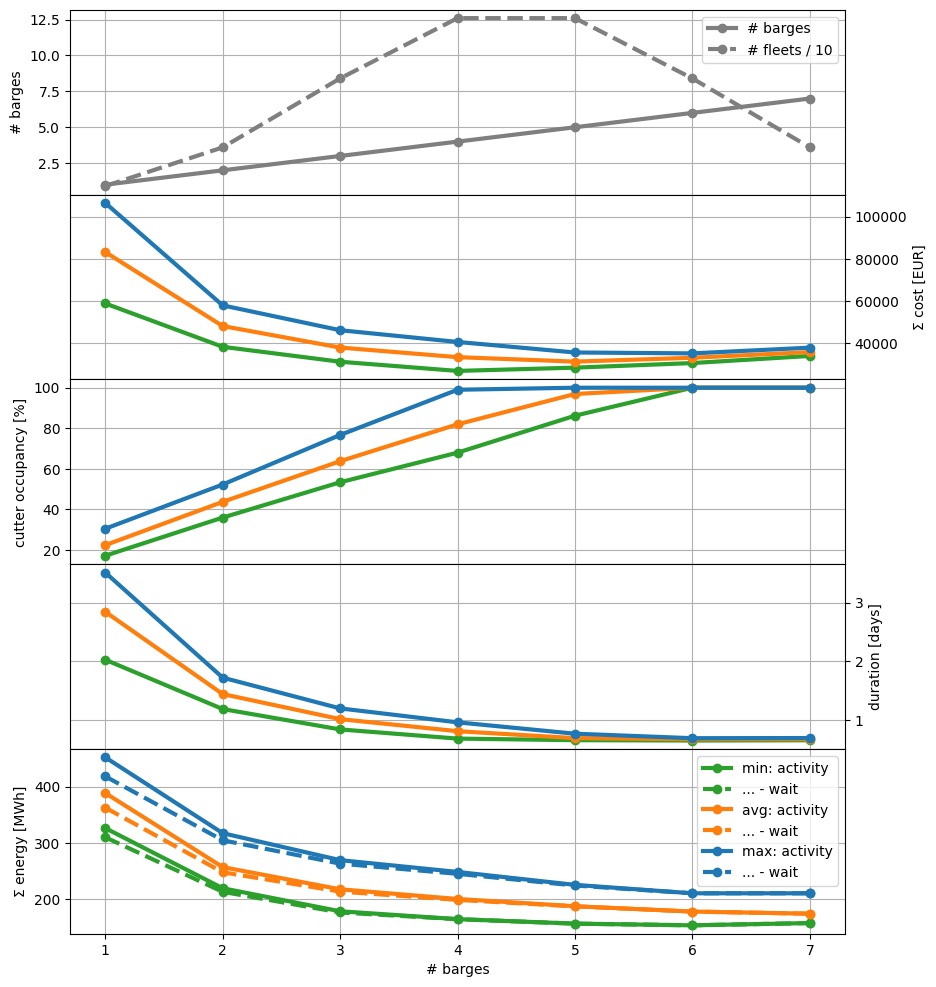

In [18]:
# plot min/avg/max simulation KPI per # barges

fig = plt.figure(figsize=(10,12))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

nfleet = scenarios.groupby('# barges').count()['duration']

mins = scenarios.groupby('# barges').min()
mins['# barges'] = mins.index
mins['# fleets'] = nfleet

avgs = scenarios.groupby('# barges').mean()
mins['# fleets'] = nfleet

maxs = scenarios.groupby('# barges').max()
mins['# fleets'] = nfleet

kpi_plot(fig, axs, [mins, avgs, maxs], ['C2','C1','C0'],['min','avg','max'],'o')
fig.savefig('figure4_24_cutters and barges scenarios', dpi=300, bbox_inches ='tight')

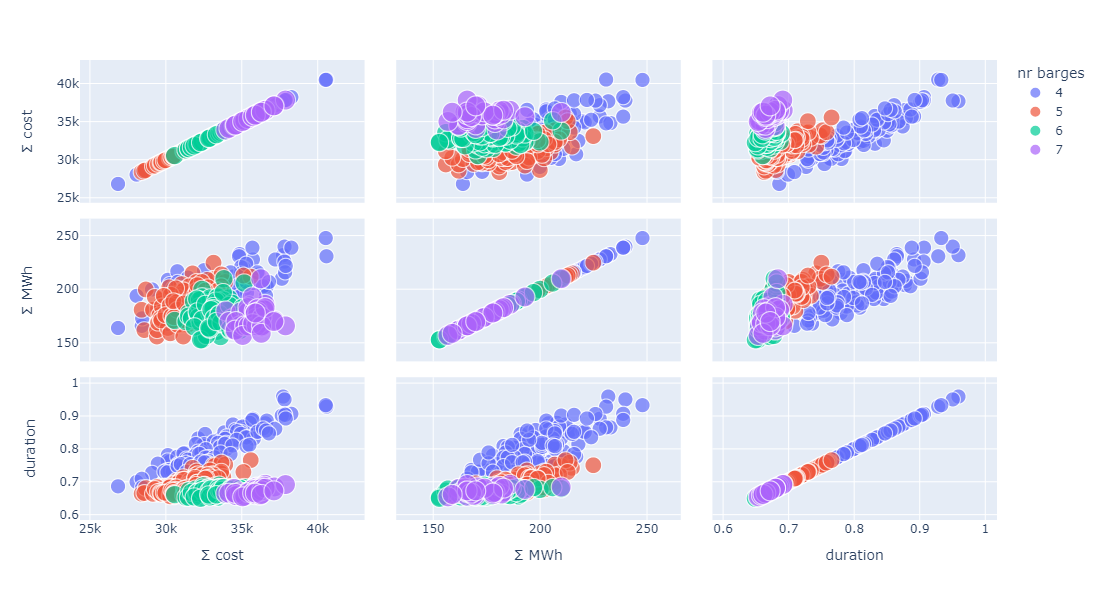

In [19]:
import plotly.express as px
scenarios['nr barges'] = [str(x) for x in scenarios['# barges']]
fig = px.scatter_matrix(scenarios[scenarios['# barges'].isin([4,5,6,7])],
                        dimensions=['Σ cost','Σ MWh','duration'],
                        color="nr barges", size='# barges', height=600)
fig.show()

In [20]:
# list top options for all # barges x KPI
li = []
criterion = []
fleet = []
for nb in range(1,6):
    tmp = scenarios[scenarios['# barges']==nb]
    if len(tmp) > 0:
        for key in ['Σ cost','duration','Σ MWh']:
            idx = tmp[[key]].idxmin().values[0]
            criterion.append(key)
            fleet.append(str(fleets[idx]))
            li.append(tmp[tmp.index==idx])
opt = pd.concat(li)
opt['criterion']=criterion
opt['fleet'] = fleet
opt.index.name='scenario'
opt.sort_values('# barges')
opt.to_csv('best.csv')
opt

# barges  cutter occupancy  duration  Σ cost  Σ MWh  Σ MWh waiting  \
scenario                                                                       
4                1              30.5  2.026863   58815    326      16.241947   
4                1              30.5  2.026863   58815    326      16.241947   
4                1              30.5  2.026863   58815    326      16.241947   
26               2              52.3  1.186583   38278    244       6.341594   
26               2              52.3  1.186583   38278    244       6.341594   
20               2              43.3  1.437719   46611    219       9.273793   
109              3              76.7  0.839093   31206    196       2.120785   
109              3              76.7  0.839093   31206    196       2.120785   
79               3              66.3  0.948374   34601    178       3.535916   
151              4              95.4  0.686347   26852    164       0.339227   
241              4              99.0  0.682755   28443    173       0.070894   
151              4              95.4  0.686347   26852    164       0.339227   
256              5              98.5  0.663700   28404    181       0.104042   
318              5              99.9  0.655619   30539    169       0.009795   
275              5             100.0  0.664849   29411    156       0.000000   

         nr barges criterion  \
scenario                       
4                1    Σ cost   
4                1  duration   
4                1     Σ MWh   
26               2    Σ cost   
26               2  duration   
20               2     Σ MWh   
109              3    Σ cost   
109              3  duration   
79               3     Σ MWh   
151              4    Σ cost   
241              4  duration   
151              4     Σ MWh   
256              5    Σ cost   
318              5  duration   
275              5     Σ MWh   

                                                      fleet  
scenario                                                     
4                                              ['Barge II']  
4                                              ['Barge II']  
4                                              ['Barge II']  
26                                   ['Barge I', 'Extra 1']  
26                                   ['Barge I', 'Extra 1']  
20                                   ['Barge I', 'Extra 2']  
109                    ['Barge I', 'Barge II', 'Barge III']  
109                    ['Barge I', 'Barge II', 'Barge III']  
79                     ['Barge II', 'Barge III', 'Extra 2']  
151          ['Barge I', 'Barge III', 'Extra 1', 'Extra 3']  
241       ['Carrier B', 'Barge I', 'Barge II', 'Barge III']  
151          ['Barge I', 'Barge III', 'Extra 1', 'Extra 3']  
256       ['Barge I', 'Barge III', 'Extra 1', 'Extra 2',...  
318       ['Carrier A', 'Carrier B', 'Barge I', 'Barge I...  
275       ['Carrier B', 'Barge I', 'Barge III', 'Extra 2...

# Analyse one scenario in detail: cheapest or a preferred fleet

In [21]:
cheapest_index = scenarios['Σ cost'].idxmin()
cheapest_index

151

In [22]:
# If you want to see a particular fleet
fleet_vessels = set(['Barge II','Carrier A','Barge III','Extra 1','Cutter T'])
for fleet_index, res in enumerate(results):
    fleet_ = set(list(res['vessels'].keys()))
    if fleet_==fleet_vessels:
        break
fleet_index,fleet_vessels

(223, {'Barge II', 'Barge III', 'Carrier A', 'Cutter T', 'Extra 1'})

In [23]:
scenario_index = fleet_index
scenario_index

223

## Example plots for 1 chosen scenario

In [24]:
vessels = results[scenario_index]['vessels']
sites = results[scenario_index]['sites']
activities = results[scenario_index]['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]
scenarios[scenarios.index==scenario_index]

# barges  cutter occupancy  duration  Σ cost  Σ MWh  Σ MWh waiting  \
223         4              87.5  0.758029   31321    199       1.016443   

    nr barges  
223         4

In [25]:
# determine occupancy per vessel

fleet, project = simulation_analysis(results[scenario_index], vessel_specs, cutter_name, total_amount)
fleet.sort_values(by=["name"])

# trips                      start                     finish  \
name                                                                       
Barge II         6 1970-01-01 00:00:00.000000 1970-01-01 17:37:51.672279   
Barge III        6 1970-01-01 00:00:00.000000 1970-01-01 18:11:33.672279   
Carrier A        5 1970-01-01 00:00:00.000000 1970-01-01 17:07:00.665049   
Cutter T         6 1970-01-01 00:33:19.975903 1970-01-01 16:52:06.701195   
Extra 1          6 1970-01-01 00:00:00.000000 1970-01-01 15:31:04.749390   

           amount sum        MWh  MWh waiting  duration actual  \
name                                                             
Barge II       9000.0  37.889335     0.014456     63471.672279   
Barge III      8155.0  33.933169     0.041622     65493.672279   
Carrier A      6125.0  33.387982     0.038571     61620.665049   
Cutter T      30000.0  63.516443     1.016443     58726.725292   
Extra 1        6720.0  29.877250     0.041239     55864.749390   

           duration theory  cost actual  production actual  production theory  \
name                                                                            
Barge II      60869.653001       3673.0           0.850773           0.887142   
Barge III     58001.653001       3790.0           0.747095           0.843597   
Carrier A     54677.971875       4279.0           0.496992           0.560098   
Cutter T      51408.333335      16993.0           3.065044           3.501378   
Extra 1       48441.710835       2586.0           0.721743           0.832341   

           occupancy [%]  
name                      
Barge II            95.9  
Barge III           88.6  
Carrier A           88.7  
Cutter T            87.5  
Extra 1             86.7

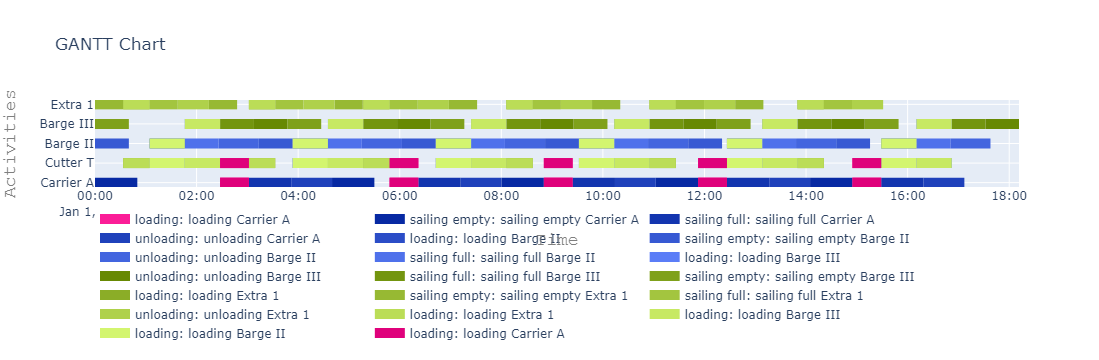

In [26]:
# activities per vessel

fig = get_gantt_chart(vessels, id_map=activities)

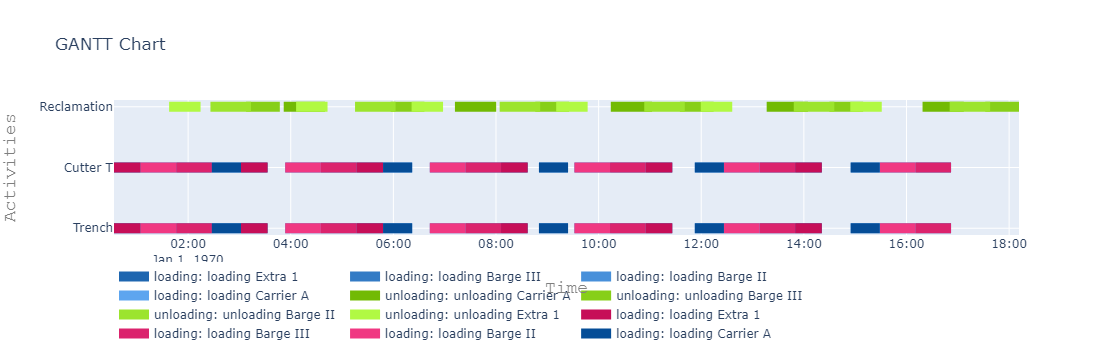

In [27]:
# activities per site and cutter

fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

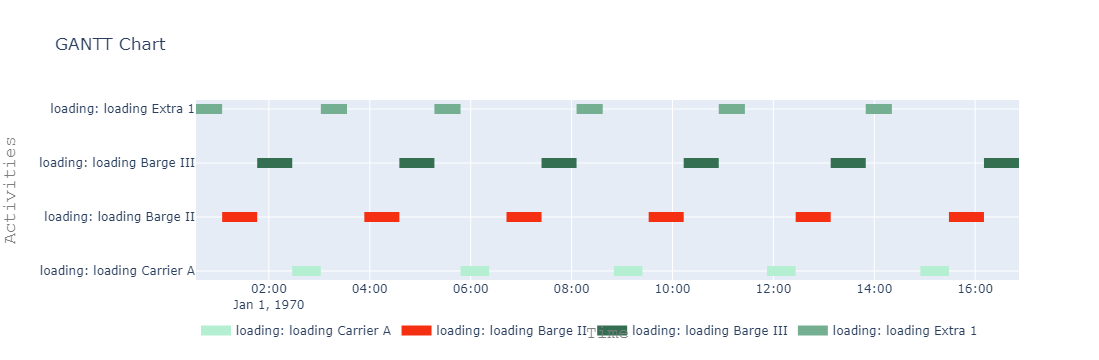

In [28]:
# Plot only activities whose namespace (first letters) matches load*: 1 activty_type

flat = pd.DataFrame(get_tree_as_list(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

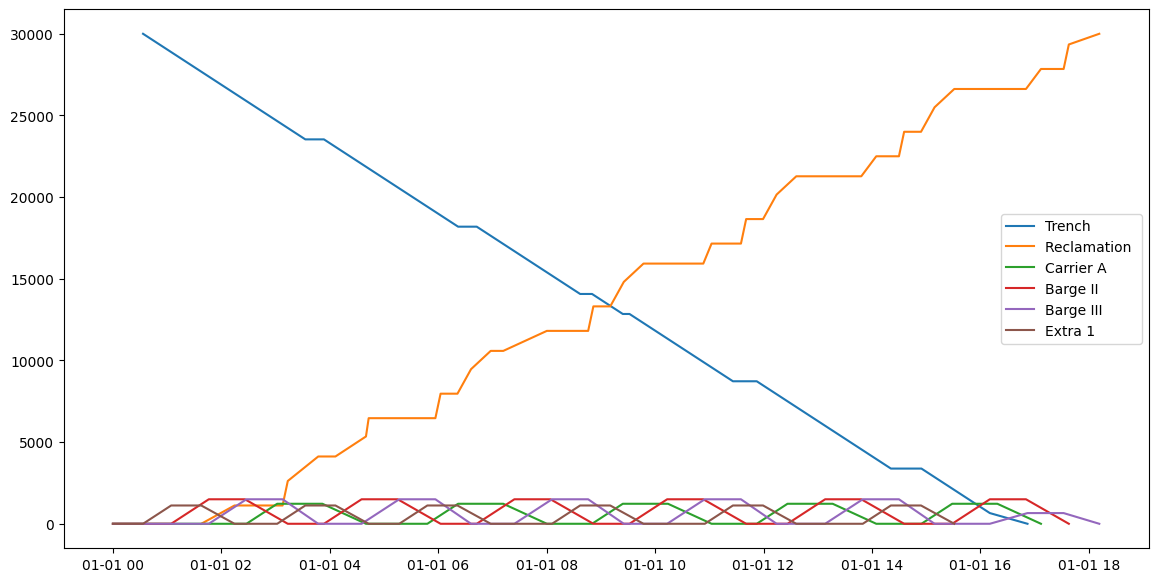

In [29]:
# plot overall amount s-curve

fig = get_step_chart([from_site, to_site, *vessels.values()])

## Export data  to BI for interactive a posteriori analysis

In [30]:
get_concepts(sites, 'Site', 'concepts_sites.csv')

SiteName                                SiteID SiteClass
0       Trench  24fdc5c1-ca65-4e36-a4dd-464c4cf417d7      Site
1  Reclamation  89bd92a8-2e3f-491c-a305-a5658db7fd46      Site

In [31]:
get_concepts(vessels, 'Vessel', 'concepts_vessels.csv')

VesselName                              VesselID  \
0  Carrier A  dccd7070-aa04-44b8-bc86-2d27886effbf   
1   Barge II  b0d0b9b3-2b46-4dd5-ba01-9f13c969eebf   
2  Barge III  41fa5eff-6395-4cf7-a56c-bdf091751ede   
3    Extra 1  12374a23-6c1a-49d0-9f05-3ec5ec81e935   
4   Cutter T  05958d06-ac8f-4d91-adeb-a8bef417b04b   

                   VesselClass  
0  TransportProcessingResource  
1  TransportProcessingResource  
2  TransportProcessingResource  
3  TransportProcessingResource  
4  TransportProcessingResource

In [32]:
concepts = get_concepts({**sites,**vessels}, 'Concept', 'concepts.csv')
concepts.head(3)

ConceptName                             ConceptID  \
0       Trench  24fdc5c1-ca65-4e36-a4dd-464c4cf417d7   
1  Reclamation  89bd92a8-2e3f-491c-a305-a5658db7fd46   
2    Carrier A  dccd7070-aa04-44b8-bc86-2d27886effbf   

                  ConceptClass  
0                         Site  
1                         Site  
2  TransportProcessingResource

In [33]:
activity_resources =  get_activity_resources(activities, 'resources.csv')
activity_resources.head(3)

ActivityID                    ActivityName  \
0  e8125df4-2505-4b55-ab13-c351b5169a4d      loading: loading Carrier A   
1  55c2a4f3-26d8-4529-b618-4794aff66bc3  unloading: unloading Carrier A   
2  178c6f0b-173e-4d01-9dd0-9f507f98917f       loading: loading Barge II   

         ActivityClass                             ConceptID ConceptName  \
0  ShiftAmountActivity  05958d06-ac8f-4d91-adeb-a8bef417b04b    Cutter T   
1  ShiftAmountActivity  dccd7070-aa04-44b8-bc86-2d27886effbf   Carrier A   
2  ShiftAmountActivity  05958d06-ac8f-4d91-adeb-a8bef417b04b    Cutter T   

  ConceptMode  
0   processor  
1   processor  
2   processor

In [34]:
activities_flat = get_activities(activities, 'activities.csv')
activities_flat.head(3)

ActivityID  \
0  255ccdba-ff41-46df-93f0-363d2b7b8e2a   
1  d4bae5c6-e822-4679-8ac0-1735cd7a3773   
2  1aebbb9c-9d53-4c5c-a8cd-8173237ebb68   

                                        ActivityName  ActivityClass ParentId  \
0  while_sequential_activity_subcycle:while_seque...  WhileActivity     None   
1  while_sequential_activity_subcycle:while_seque...  WhileActivity     None   
2  while_sequential_activity_subcycle:while_seque...  WhileActivity     None   

  ParentName  ParentLevel                                           activity  \
0                       0  <openclsim.model.while_activity.WhileActivity ...   
1                       0  <openclsim.model.while_activity.WhileActivity ...   
2                       0  <openclsim.model.while_activity.WhileActivity ...   

  ProcessorID MoverID OriginID DestinationID ProcessorName MoverName  \
0        None    None     None          None                           
1        None    None     None          None                           
2        None    None     None          None                           

  OriginName DestinationName  
0                             
1                             
2

In [35]:
activities_log = get_activity_log(activities, 'activity_logs.csv')
activities_log.head(3)

TimestampStart  trip              TimestampStop  \
0       1970-01-01     1 1970-01-01 04:40:02.273090   
210     1970-01-01     1 1970-01-01 00:33:19.975903   
21      1970-01-01     2 1970-01-01 04:43:01.951806   

                               ActivityID   TimestampDt  \
0    255ccdba-ff41-46df-93f0-363d2b7b8e2a  16802.273090   
210  1d0f7df9-7ceb-462f-bbf1-a0032a809faa   1999.975903   
21   fb8db229-591a-4f53-bfaf-f0a4abfffdff  16981.951806   

                                          ActivityName  ActivityClass  
0    while_sequential_activity_subcycle:while_seque...  WhileActivity  
210               sailing empty: sailing empty Extra 1   MoveActivity  
21   while_sequential_activity_subcycle:while_seque...  WhileActivity

## Verification/sanity checks

In [36]:
set(activities_flat['MoverName'])

{'', 'Barge II', 'Barge III', 'Carrier A', 'Extra 1'}

In [37]:
set(activities_flat['ProcessorName'])

{'', 'Barge II', 'Barge III', 'Carrier A', 'Cutter T', 'Extra 1'}

In [38]:
set(activities_flat['OriginName'])

{'', 'Barge II', 'Barge III', 'Carrier A', 'Extra 1', 'Trench'}

In [39]:
set(activities_flat['DestinationName'])

{'', 'Barge II', 'Barge III', 'Carrier A', 'Extra 1', 'Reclamation', 'Trench'}

In [40]:
set(activities_flat['ActivityClass'])

{'MoveActivity', 'SequentialActivity', 'ShiftAmountActivity', 'WhileActivity'}

In [41]:
set(activities_flat['OriginName'])

{'', 'Barge II', 'Barge III', 'Carrier A', 'Extra 1', 'Trench'}

In [42]:
set(activity_resources['ConceptMode'])

{'destination', 'mover', 'origin', 'processor'}

In [77]:
# check that OpenCLSim sailing times are correct
t = []
for v in vessel_specs[vessel_specs['vessel_type']=='barge'].index:
    t.append(round(sailing_distance/vessel_specs.loc[v]['speed [m/s]'],2))
set(t) == set([round(x,2) for x in activities_log[activities_log['ActivityClass']=='MoveActivity']['TimestampDt']])
set(t)

{1999.98, 2399.97, 2999.96}